## 01-02-2025

# Module 4: PCA & Feature Selection

**Purpose:**
Perform PCA and feature selection to identify discriminative features for ALS vs Control classification.

## Critical: Discovery Set Only!

**All feature selection uses DISCOVERY SET ONLY (n=8)**
- Discovery: 4 ALS, 4 Control
- Validation: **LOCKED** 

## Four Analyses:

### 1. **High-Variance Fragmentomics (K-mers)**
   - Select k-mers with highest variance
   - PCA to visualize natural variation
   
### 2. **Discriminative Fragmentomics (K-mers)**
   - Select k-mers that differ between ALS vs Control
   - PCA to visualize disease separation
   
### 3. **High-Variance Methylation (Regional Bins)**
   - Select regional methylation bins with highest variance
   - PCA to visualize natural variation
   
### 4. **Discriminative Methylation (Regional Bins)**
   - Select bins that differ between ALS vs Control
   - PCA to visualize disease separation

## Selection Strategy:

For each analysis:
1. Filter features (≥25% sample coverage, ≥2/8 samples)
2. Select top 30 features (high variance OR discriminative)
3. Perform PCA on selected features
4. Visualize separation by disease status

Compare all 4 analyses:
- Which shows best separation (PC1+PC2 variance)?
- Select best feature set for classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# Import Module 4
from src.feature_selection import run_module_4

# Import config
from src.config import (
    ALL_FEATURES,
    PCA_FIGURES_DIR,
    FEATURE_RANKINGS_DIR,
    SELECTED_FEATURES_FILE,
    PCA_COMPARISON_FILE,
    N_TOP_FEATURES_PER_ANALYSIS
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## Run Module 4

This will:
1. Load data and split to Discovery (n=8) / Validation (n=14)
2. Run 4 feature selection analyses
3. Generate 4 PCA plots
4. Compare analyses and select best feature set

In [2]:
# Run complete Module 4 pipeline
results = run_module_4()


MODULE 4: PCA & Feature Selection

CRITICAL: Using DISCOVERY SET ONLY (n=8)
Validation set remains locked until Module 6

Loading and splitting data:
----------------------------------------------------------------------
Total samples: 22

Discovery set: 8 samples
  ALS: 4
  Control: 4

Validation set: 14 samples (LOCKED until Module 6)
  ALS: 8
  Control: 6

ANALYSIS 1: High-Variance Fragmentomics (K-mers)

Starting features: 256 k-mers
  Coverage filter (≥2/8 samples):
    Input: 256 features
    Output: 256 features
    Removed: 0 features
  Variance filter (var ≥ 0.001):
    Input: 256 features
    Output: 76 features
    Removed: 180 features

  Selecting top 30 high-variance features...
    Ranked 76 features by variance
    Top feature: kmer_AAAA (var=0.3207)

  ✓ Saved rankings to: fragmentomics_high_variance.csv

  Performing PCA...
    PCA computed: 30 features → 8 PCs
    PC1 variance: 66.8%
    PC2 variance: 13.3%
    PC1+PC2 total: 80.0%
    ✓ Saved: pca_fragmentomics:_hi

## Extract Results

In [6]:
# Extract key results
discovery_df = results['discovery_df']
validation_df = results['validation_df']
final_features = results['final_features']
feature_sets = results['feature_sets']

print("Module 4 Results:")
print("=" * 70)
print(f"\nDiscovery set: {discovery_df.shape}")
print(f"Validation set: {validation_df.shape} (LOCKED)")
print(f"\nFinal feature set: {final_features.shape}")
print(f"  Metadata columns: 4 (sample_id, disease_status, batch, age)")
print(f"  Selected features: {final_features.shape[1] - 4}")

print("\nFeature set breakdown:")
for name, feats in feature_sets.items():
    print(f"  {name}: {len(feats)} features")


Module 4 Results:

Discovery set: (8, 1236)
Validation set: (14, 1236) (LOCKED)

Final feature set: (8, 108)
  Metadata columns: 4 (sample_id, disease_status, batch, age)
  Selected features: 104

Feature set breakdown:
  frag_highvar: 30 features
  frag_discriminative: 30 features
  meth_highvar: 30 features
  meth_discriminative: 30 features


## View PCA Plots (All 4 Analyses)

PCA Plots (Discovery Set Only, n=8):

1. Fragmentomics: Discriminative K-Mers
----------------------------------------------------------------------


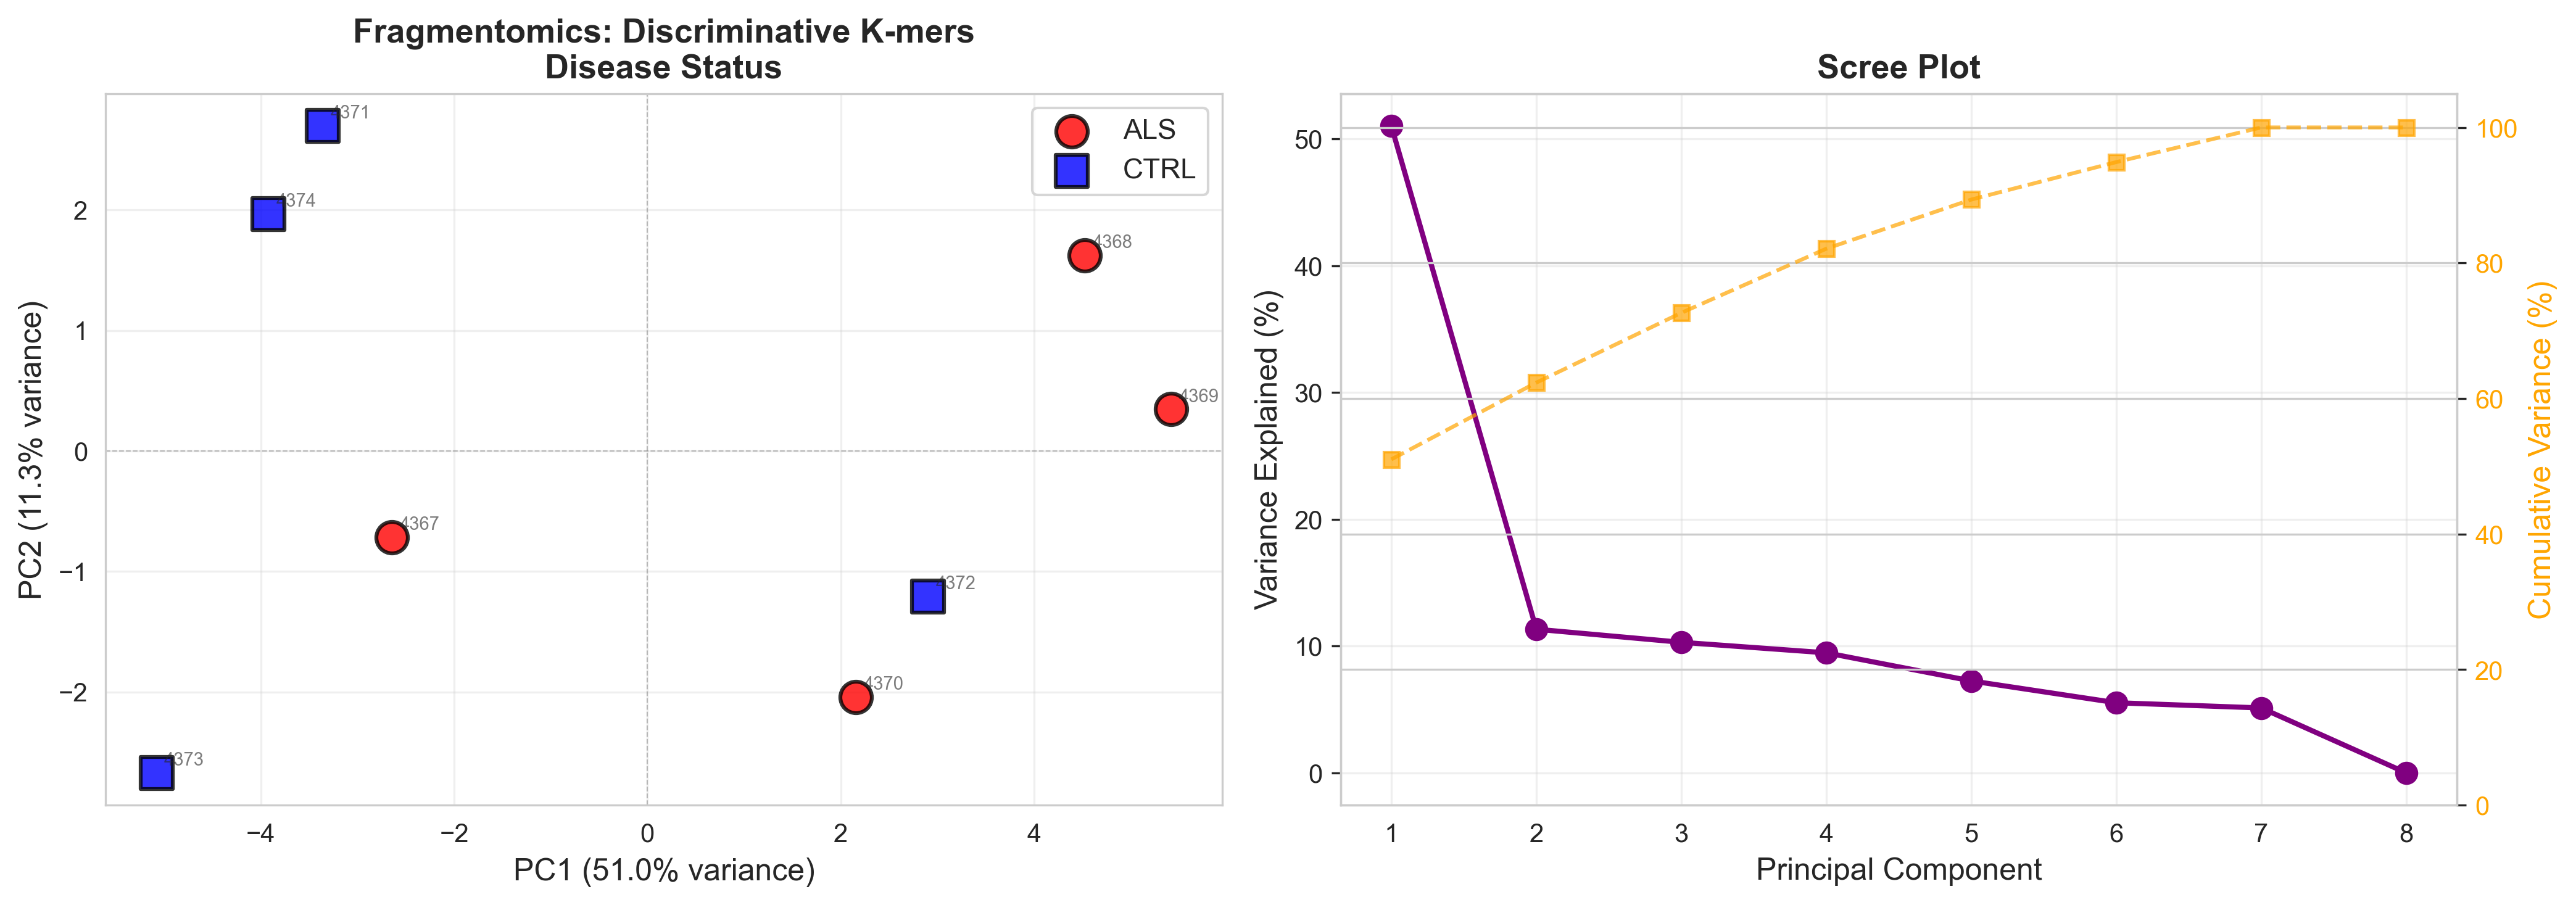


2. Fragmentomics: High-Variance K-Mers
----------------------------------------------------------------------


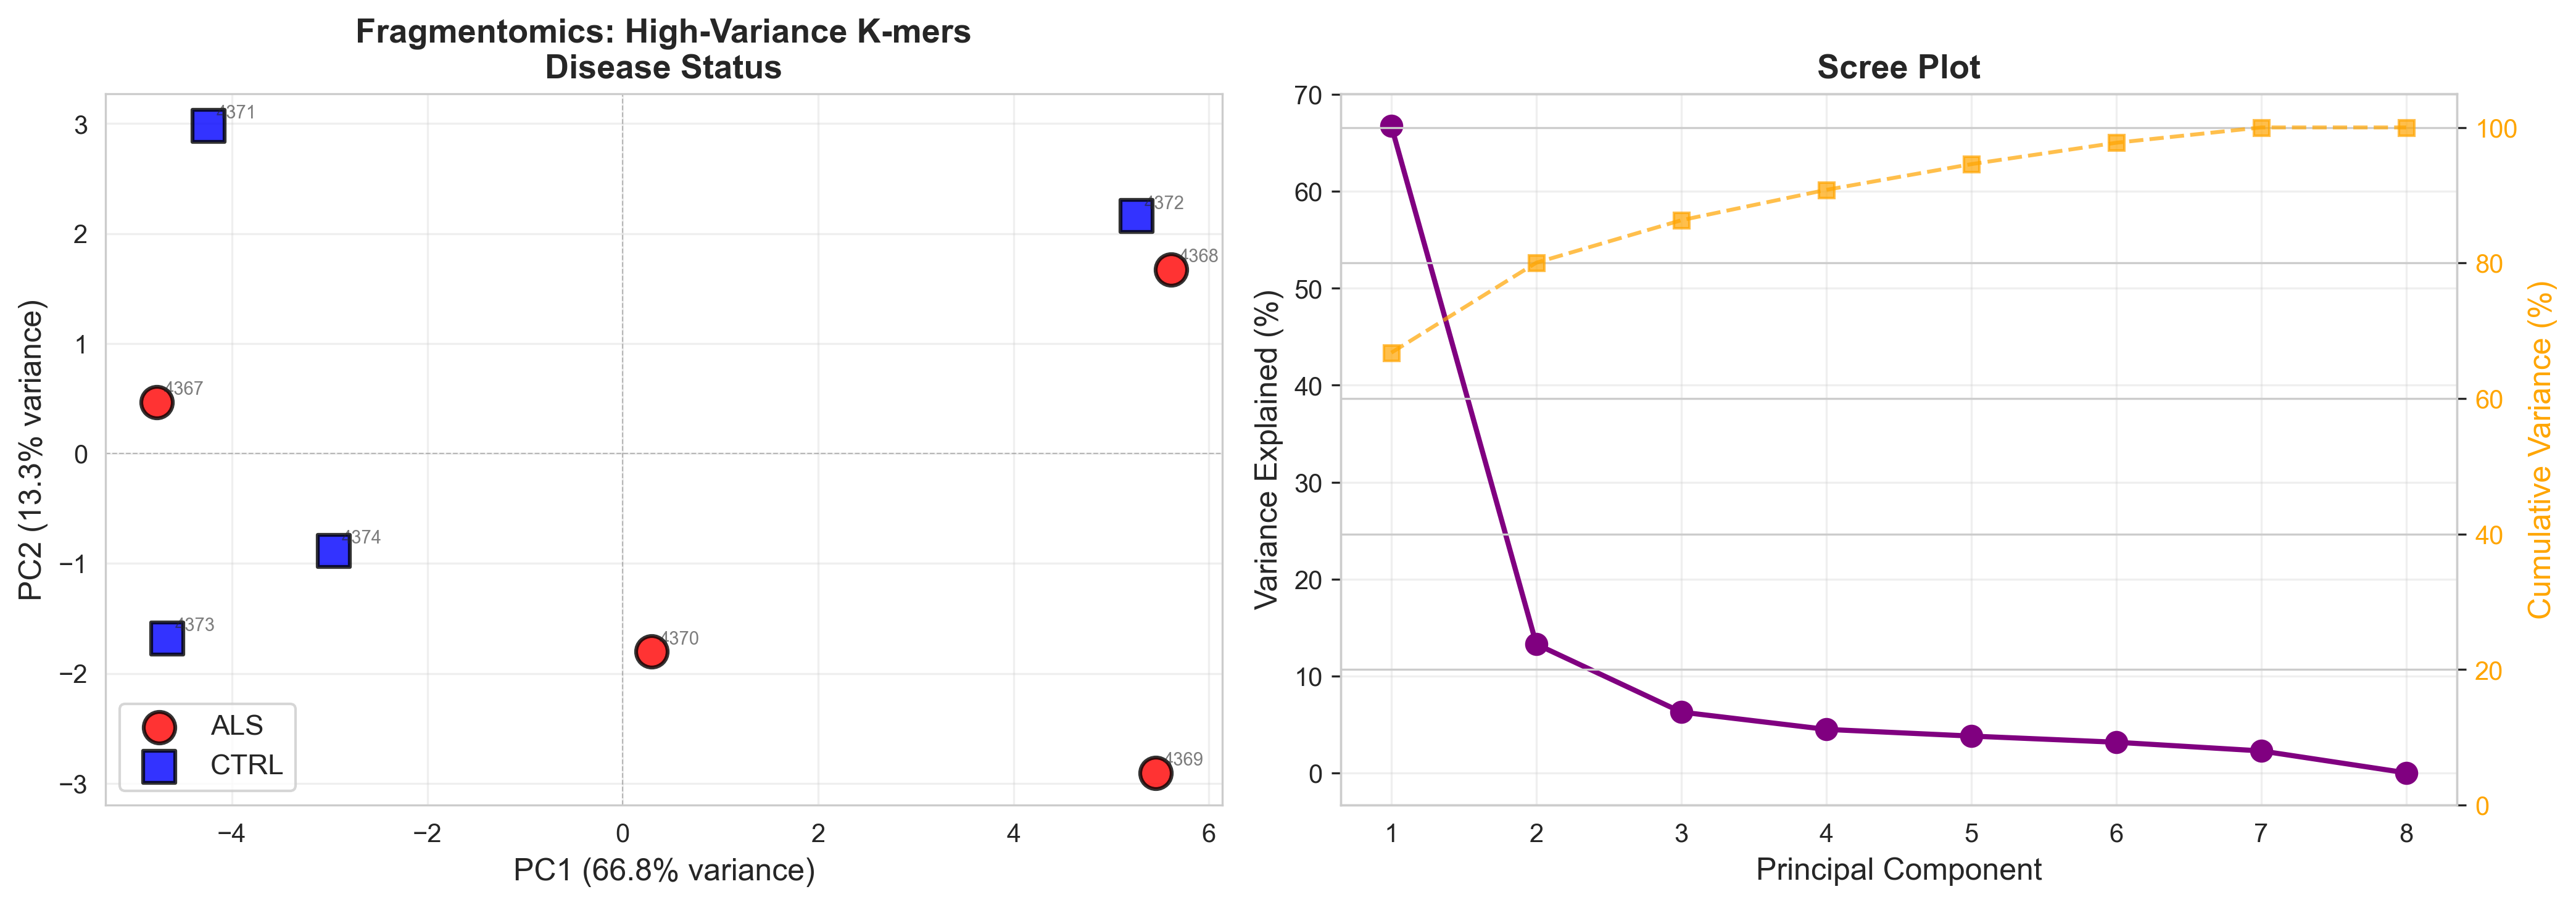


3. Methylation: Discriminative Regional Bins
----------------------------------------------------------------------


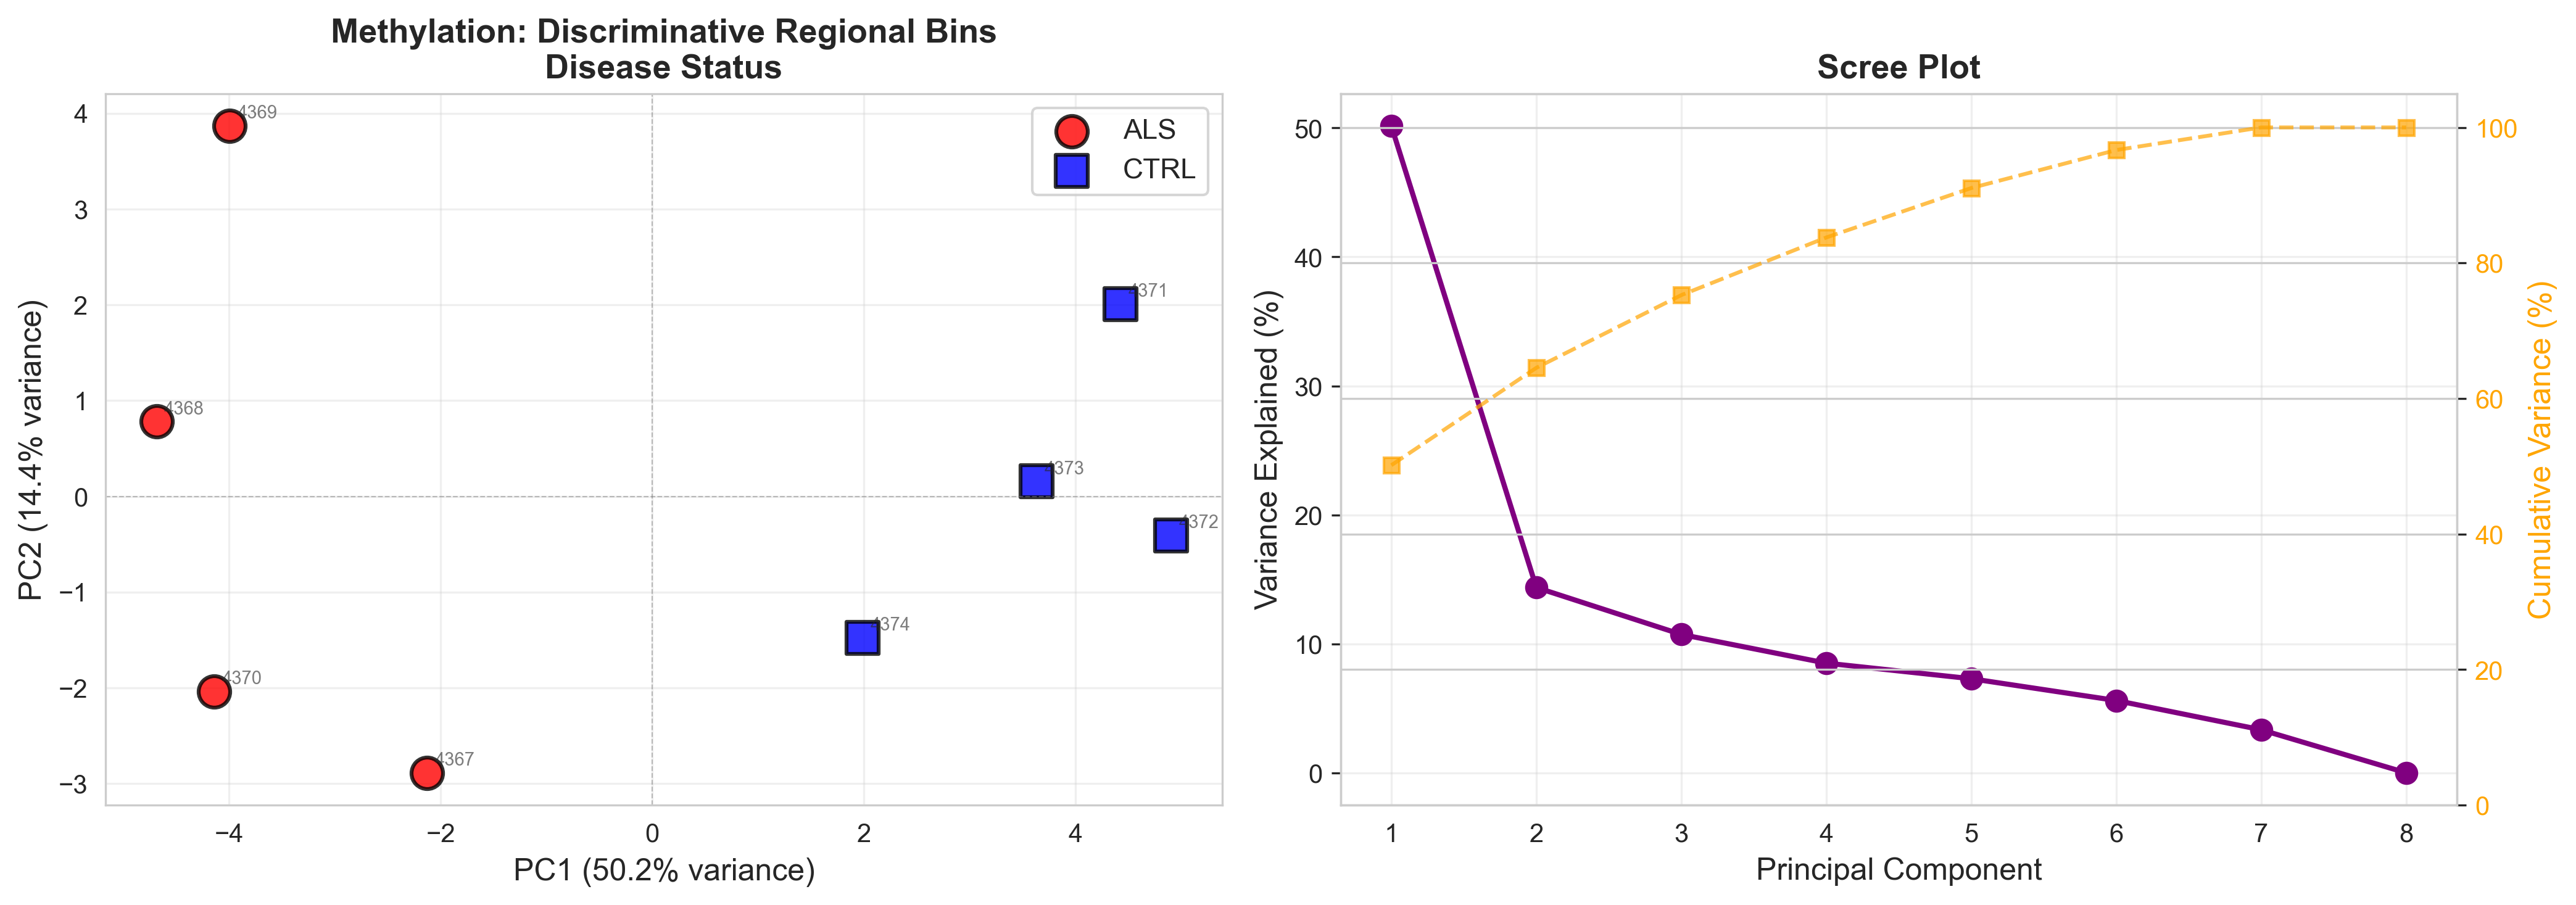


4. Methylation: High-Variance Regional Bins
----------------------------------------------------------------------


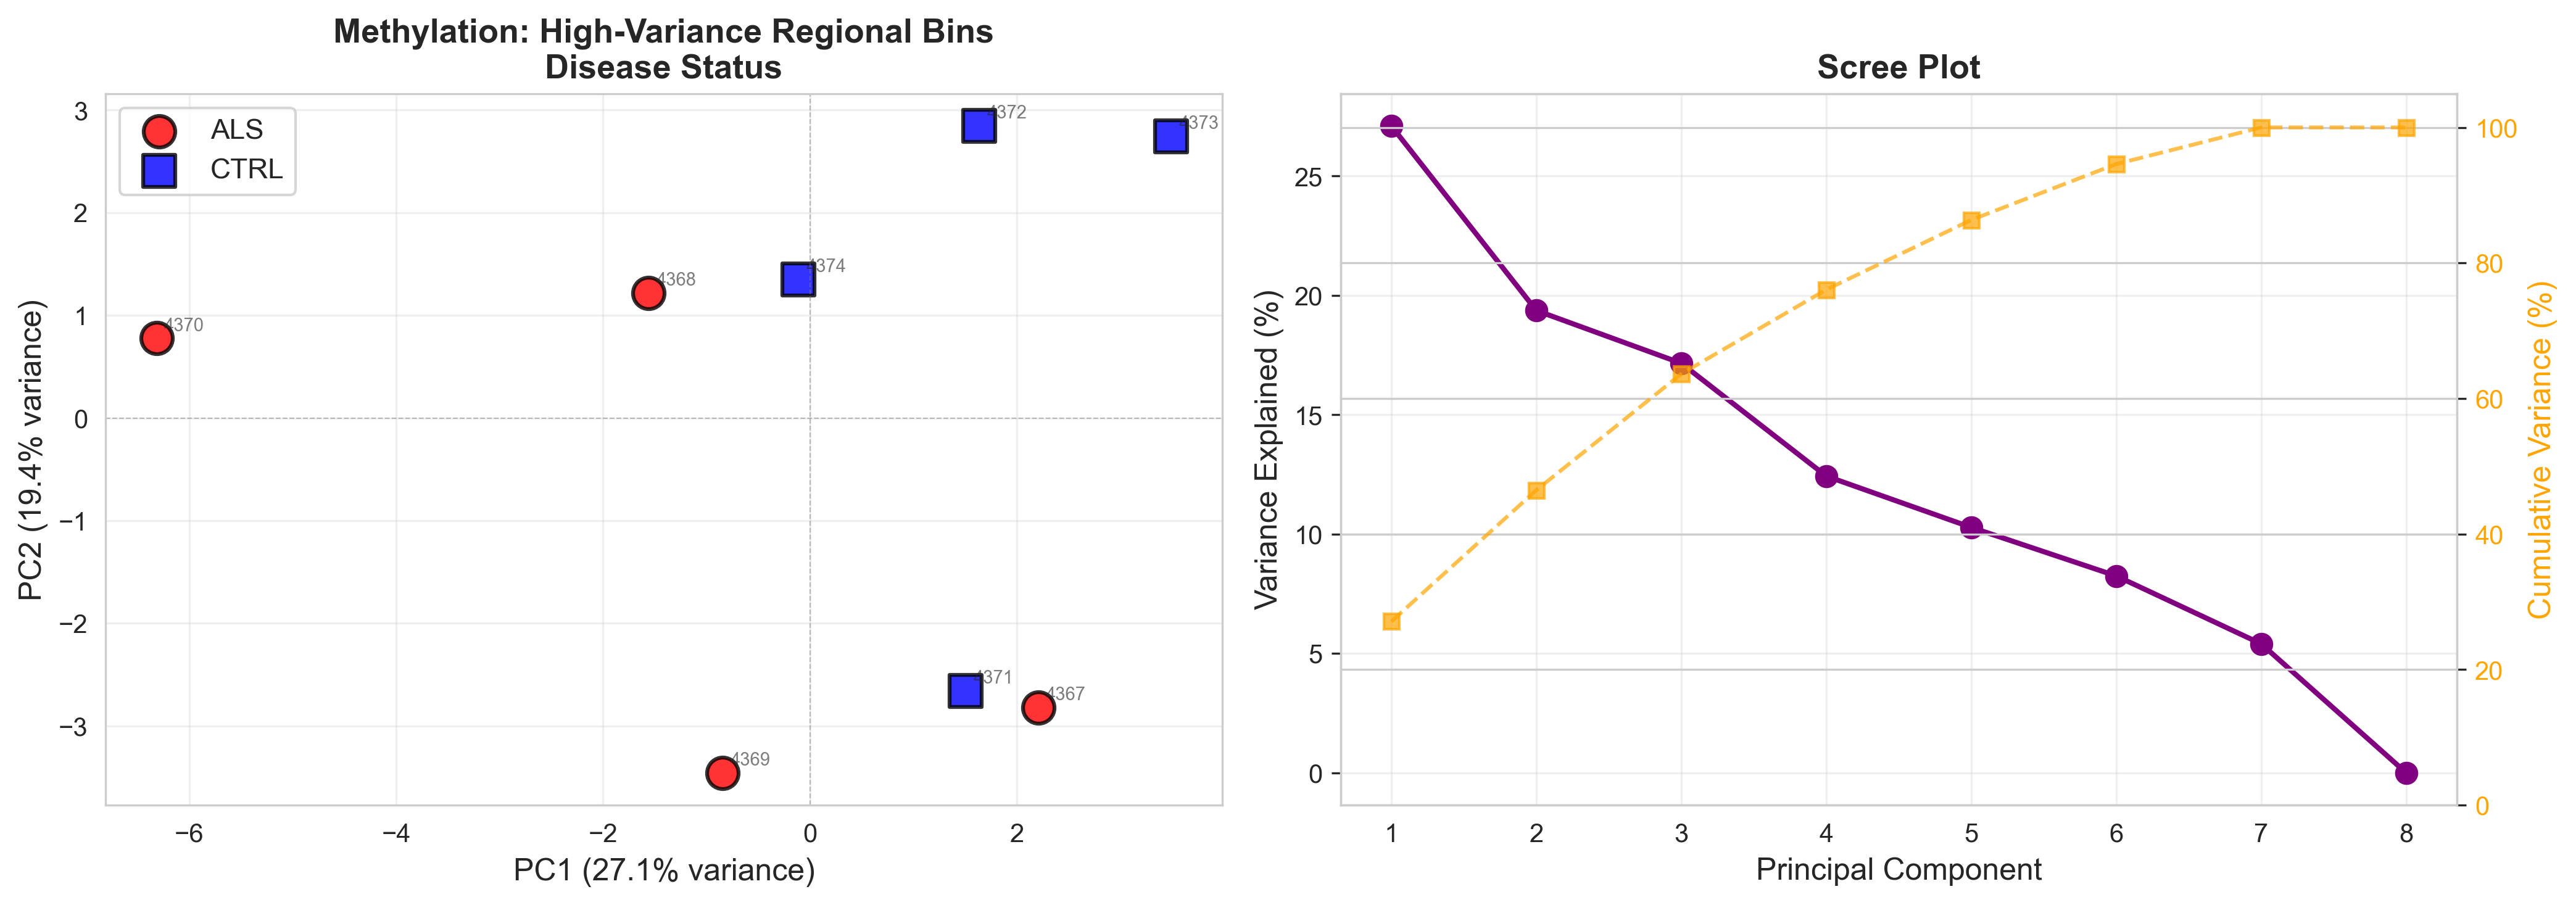

In [7]:
print("PCA Plots (Discovery Set Only, n=8):")
print("=" * 70)

# Display all PCA plots
pca_files = sorted(PCA_FIGURES_DIR.glob('pca_*.png'))

for i, pca_file in enumerate(pca_files, 1):
    title = pca_file.stem.replace('pca_', '').replace('_', ' ').title()
    print(f"\n{i}. {title}")
    print("-" * 70)
    display(Image(filename=str(pca_file)))

## Bar plot: variance explained by each feature set

                                 Feature Set  PC1 + PC2 (%)
0        Fragmentomics: High-Variance K-mers      80.041165
1       Fragmentomics: Discriminative K-mers      62.347102
2   Methylation: High-Variance Regional Bins      46.475088
3  Methylation: Discriminative Regional Bins      64.528682


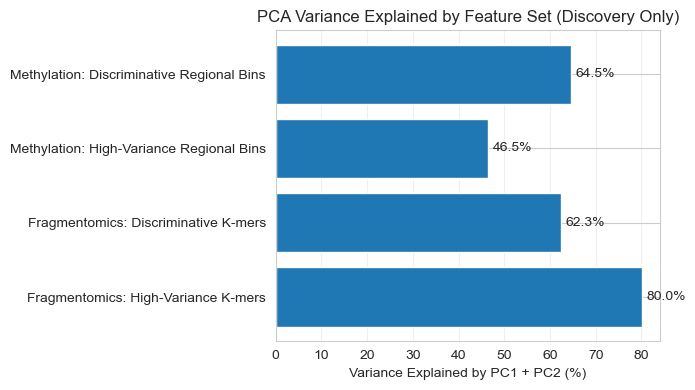

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect variance explained from PCA results
pca_results = results['all_pca_results']

summary = []
for res in pca_results:
    summary.append({
        'Feature Set': res['analysis'],
        'PC1 Variance (%)': res['pc1_variance'],
        'PC2 Variance (%)': res['pc2_variance'],
        'PC1 + PC2 (%)': res['total_variance']
    })

summary_df = pd.DataFrame(summary)

print(summary_df[['Feature Set', 'PC1 + PC2 (%)']])

fig, ax = plt.subplots(figsize=(7, 4))

ax.barh(
    summary_df['Feature Set'],
    summary_df['PC1 + PC2 (%)']
)

ax.set_xlabel('Variance Explained by PC1 + PC2 (%)')
ax.set_title('PCA Variance Explained by Feature Set (Discovery Only)')
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(summary_df['PC1 + PC2 (%)']):
    ax.text(v + 1, i, f"{v:.1f}%", va='center')


plt.tight_layout()
plt.show()



## Feature Overlap Between Analyses

In [9]:
print("Feature Overlap Between Analyses")
print("=" * 70)

feature_sets = results['feature_sets']

sets = {k: set(v) for k, v in feature_sets.items()}

for name, s in sets.items():
    print(f"{name}: {len(s)} features")

print("\nPairwise overlaps:")
keys = list(sets.keys())

for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        a, b = keys[i], keys[j]
        overlap = len(sets[a] & sets[b])
        print(f"  {a} ∩ {b}: {overlap}")


Feature Overlap Between Analyses
frag_highvar: 30 features
frag_discriminative: 30 features
meth_highvar: 30 features
meth_discriminative: 30 features

Pairwise overlaps:
  frag_highvar ∩ frag_discriminative: 12
  frag_highvar ∩ meth_highvar: 0
  frag_highvar ∩ meth_discriminative: 0
  frag_discriminative ∩ meth_highvar: 0
  frag_discriminative ∩ meth_discriminative: 0
  meth_highvar ∩ meth_discriminative: 4


## Top Methylation Signal

Top discriminative methylation feature: regional_meth_bin_129


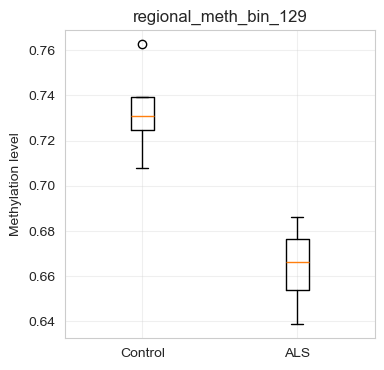

In [10]:
import matplotlib.pyplot as plt

meth_disc = feature_sets['meth_discriminative']
top_meth = meth_disc[0]

print(f"Top discriminative methylation feature: {top_meth}")

fig, ax = plt.subplots(figsize=(4, 4))

als_vals = discovery_df[discovery_df['disease_status'] == 'als'][top_meth]
ctrl_vals = discovery_df[discovery_df['disease_status'] == 'ctrl'][top_meth]

ax.boxplot([ctrl_vals, als_vals], labels=['Control', 'ALS'])
ax.set_ylabel("Methylation level")
ax.set_title(top_meth)
ax.grid(alpha=0.3)

plt.show()


### Important Note: Variance vs Discrimination

**Highest Variance:** Fragmentomics Highly Variable features (80% variance)

**Visual inspection of PCA plots reveals:**
- High-variance fragmentomics: PC1 somewhat driven by disease
- Discriminative methylation: PC1 clearly separates ALS vs Control

**Discriminative methylation:**
1. Visual inspection shows clearest disease separation
2. PC1 (50%) separates ALS from Control

Fragmentomics features explain the greatest overall variance in cfDNA profiles, whereas discriminative methylation features explain less total variance but show the strongest disease-specific separation. These signals are largely orthogonal, combined use for classification